In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import pickle
from sklearn.metrics import roc_auc_score
import optuna
import catboost as cb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/purple-hack/train_ai_comp_final_dp.parquet


In [2]:
df = pd.read_parquet('/kaggle/input/purple-hack/train_ai_comp_final_dp.parquet')

In [5]:
for col in df.columns:
    if df[col].dtype == 'int64':
        df[col] = df[col].astype('int32')
    elif df[col].dtype == 'float64':
        df[col] = df[col].astype('float32')
    elif df[col].dtype == 'object':
        if len(df[col].unique()) / len(df[col]) < 0.5:
            df[col] = df[col].astype('category')

## Correlation & NaNs

In [6]:
# Удаление фичей, которые коррелируют друг с другом больше, чем на 0.9
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [7]:
clean_df = df.copy()
nan_percentage = (clean_df == 0).mean()
cols_to_drop = list(nan_percentage[nan_percentage > 0.95].index)

ignore_features = ['id', 'target', 'sample_ml_new', 'feature756']+cols_to_drop
print(len(ignore_features))
clean_df = clean_df.drop(columns=ignore_features)

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False), columns=clean_df.columns, index=clean_df.columns)

194


In [9]:
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.95)
len(corr_feats)

Get correlated features:  23%|██▎       | 204/886 [00:00<00:00, 2020.04it/s]

feature1 -> ['feature1' 'feature812']
feature2 -> ['feature2' 'feature814']
feature3 -> ['feature3' 'feature933']
feature5 -> ['feature5' 'feature13' 'feature317' 'feature348' 'feature858'
 'feature860']
feature6 -> ['feature6' 'feature351' 'feature853' 'feature863']
feature7 -> ['feature7' 'feature8' 'feature10' 'feature11' 'feature14' 'feature15'
 'feature16' 'feature242' 'feature245' 'feature246' 'feature247'
 'feature248' 'feature249' 'feature259' 'feature267' 'feature598'
 'feature600' 'feature601' 'feature602' 'feature603' 'feature604'
 'feature608' 'feature609' 'feature610' 'feature611' 'feature612'
 'feature681' 'feature696']
feature12 -> ['feature12' 'feature347' 'feature859']
feature14 -> ['feature7' 'feature8' 'feature10' 'feature11' 'feature14' 'feature15'
 'feature242' 'feature245' 'feature246' 'feature247' 'feature248'
 'feature249' 'feature259' 'feature267' 'feature598' 'feature600'
 'feature601' 'feature602' 'feature603' 'feature604' 'feature608'
 'feature609' 'feature6

Get correlated features: 100%|██████████| 886/886 [00:00<00:00, 2571.00it/s]

feature436 -> ['feature429' 'feature436']
feature445 -> ['feature443' 'feature445']
feature448 -> ['feature448' 'feature487']
feature466 -> ['feature431' 'feature466']
feature468 -> ['feature468' 'feature646']
feature483 -> ['feature403' 'feature483']
feature487 -> ['feature448' 'feature487']
feature488 -> ['feature488' 'feature494']
feature494 -> ['feature488' 'feature494']
feature495 -> ['feature495' 'feature691']
feature523 -> ['feature392' 'feature523']
feature539 -> ['feature539' 'feature655']
feature542 -> ['feature542' 'feature895']
feature543 -> ['feature543' 'feature573']
feature559 -> ['feature559' 'feature560']
feature591 -> ['feature232' 'feature235' 'feature236' 'feature237' 'feature238'
 'feature239' 'feature240' 'feature241' 'feature252' 'feature253'
 'feature254' 'feature255' 'feature256' 'feature263' 'feature271'
 'feature579' 'feature580' 'feature581' 'feature582' 'feature583'
 'feature584' 'feature585' 'feature586' 'feature589' 'feature590'
 'feature591' 'feature592'

275

In [10]:
df_no_corr = clean_df.drop(columns=corr_feats)
print("Было:", df.shape)
print("Стало:", df_no_corr.shape)

Было: (519615, 1079)
Стало: (519615, 611)


## Training

In [58]:
class Boosting:

    def __init__(self, X_train, X_val, y_train, y_val, cat_features = None, params = None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(data = X_train, label = y_train, cat_features = cat_features)
        self.val_pool = cb.Pool(data = X_val, label = y_val, cat_features = cat_features)
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostClassifier(
                random_seed = 42,
                loss_function = 'Logloss',
                iterations = 1000,
                use_best_model = True,
                verbose = 100,
                thread_count = -1,
                early_stopping_rounds = 100,
                eval_metric = 'AUC'
            )
        else:
            self.params["verbose"] = 100
            model = cb.CatBoostClassifier(**self.params)

        model.fit(
            self.train_pool,
            eval_set = self.val_pool
        )

        y_train_pred = model.predict_proba(self.X_train)[:, 1]
        y_val_pred = model.predict_proba(self.X_val)[:, 1]

        roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

        print("ROC AUC на обучающей выборке:", roc_auc_tr)
        print("ROC AUC на валидационной выборке:", roc_auc_val)

        self.model = model

    def optimize_hyperparams(self):

        def objective(trial):
            params = {
                "objective" : trial.suggest_categorical("objective", ["Logloss"]),
                "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
                "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
                "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
                "depth" : trial.suggest_int("depth", 2, 5),
                "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
                "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
                "iterations" : trial.suggest_int("iterations", 500, 3500),
                "eval_metric" : "AUC"
            }

            if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
            elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

            model = cb.CatBoostClassifier(
                loss_function = 'Logloss',
                random_seed = 42,
                task_type = 'CPU',
                use_best_model = True,
                verbose = False,
                **params
            )

            model.fit(
                self.train_pool,
                eval_set = self.val_pool
            )

            y_pred = model.predict_proba(self.X_val)[:, 1]

            roc_auc = roc_auc_score(self.y_val, y_pred)

            return roc_auc

        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
        study.optimize(objective, n_trials = 100, timeout = 1800)

        self.best_params = study.best_params

        print("Best params:", self.best_params)

    def save_model(self, file_path):
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        if len(feature_importance) > 100:
            sorted_idx = np.argsort(feature_importance)[550:]
        else:
            sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx])
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)

    def top_feats_selection(self):

        top = []
        roc_tr = []
        roc_val = []

        for col in tqdm.tqdm(self.top_features[:30]):

            top.append(col)

            train_pool = cb.Pool(data = self.X_train[top], label = self.y_train)
            val_pool = cb.Pool(data = self.X_val[top], label = self.y_val)

            if self.params is None:
                model = cb.CatBoostClassifier(
                    random_seed = 42,
                    loss_function = 'Logloss',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = 100,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC'
                )
                path = "no_optuna_top_features.xlsx"
            else:
                self.params["verbose"] = 0
                self.params["iterations"] = 500
                path = "optuna_top_features.xlsx"
                model = cb.CatBoostClassifier(**self.params)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[top])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[top])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

            roc_tr.append(roc_auc_tr)
            roc_val.append(roc_auc_val)

        plt.figure(figsize=(15, 10))
        plt.plot(range(len(self.top_features[:30])), roc_tr, marker = 'o', label = 'Train')
        plt.plot(range(len(self.top_features[:30])), roc_val, marker = 'o', label = 'Valid')
        plt.xlabel("Number of Top Features")
        plt.ylabel("ROC AUC")
        plt.title("ROC AUC on Top-K Features")
        plt.legend()
        plt.show()

        stats = pd.DataFrame({
            "TRAIN" : roc_tr,
            "VALID" : roc_val
        })

    def one_factor_roc(self):
        story = pd.DataFrame()

        for feature in tqdm.tqdm(self.X_train.columns):
            if self.params is None:
                model = cb.CatBoostClassifier(
                    random_seed = 42,
                    loss_function = 'Logloss',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = 100,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC'
                )
                path = "no_optuna_one_factor_roc.xlsx"
            else:
                self.params["verbose"] = False
                self.params["iterations"] = 500
                path = "optuna_one_factor_roc.xlsx"
                model = cb.CatBoostClassifier(**self.params)

            if feature in self.cat_features:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train, cat_features = [feature])
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val, cat_features = [feature])
            else:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train)
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[[feature]])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[[feature]])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

            story = story.append(pd.DataFrame({
                'features' : [feature],
                'train' : [roc_auc_tr],
                'valid' : [roc_auc_val]
            }), ignore_index = True)

        plt.figure(figsize=(10, 7))
        plt.bar(range(len(story['features'])), story['train'], align = 'center', label = 'Train')
        plt.bar(range(len(story['features'])), story['valid'], align = 'edge', label = 'Valid')
        plt.xlabel("Features")
        plt.ylabel("ROC-AUC")
        plt.title("One-Factor ROC-AUC")
        plt.xticks(range(len(story['features'])), story['features'], rotation = 45)
        plt.legend()
        plt.tight_layout()

In [19]:
final_feats = df_no_corr.columns

X = df[final_feats]
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=True, stratify = y,test_size=0.25)

In [20]:
boosting = Boosting(X_train, X_val, y_train, y_val)

Init...
Init Finished!


In [21]:
boosting.train()

Learning rate set to 0.1383
0:	test: 0.5773206	best: 0.5773206 (0)	total: 512ms	remaining: 8m 31s
100:	test: 0.7544561	best: 0.7544819 (99)	total: 53.5s	remaining: 7m 56s
200:	test: 0.7567163	best: 0.7567989 (177)	total: 1m 39s	remaining: 6m 35s
300:	test: 0.7575796	best: 0.7576691 (287)	total: 2m 25s	remaining: 5m 37s
400:	test: 0.7582683	best: 0.7583644 (338)	total: 3m 10s	remaining: 4m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7583644361
bestIteration = 338

Shrink model to first 339 iterations.
ROC AUC на обучающей выборке: 0.7944965032990718
ROC AUC на валидационной выборке: 0.7583644360550653


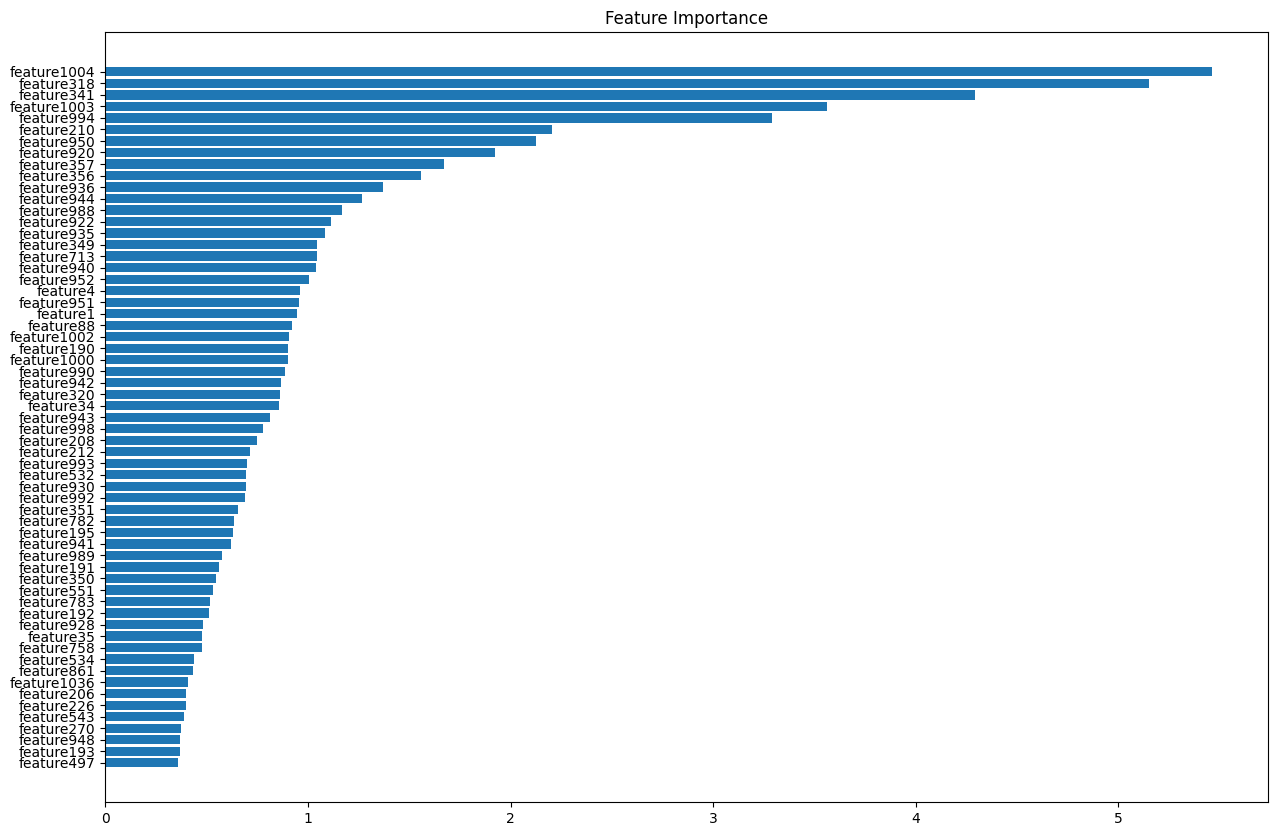

['feature1004' 'feature318' 'feature341' 'feature1003' 'feature994'
 'feature210' 'feature950' 'feature920' 'feature357' 'feature356'
 'feature936' 'feature944' 'feature988' 'feature922' 'feature935'
 'feature349' 'feature713' 'feature940' 'feature952' 'feature4'
 'feature951' 'feature1' 'feature88' 'feature1002' 'feature190'
 'feature1000' 'feature990' 'feature942' 'feature320' 'feature34'
 'feature943' 'feature998' 'feature208' 'feature212' 'feature993'
 'feature532' 'feature930' 'feature992' 'feature351' 'feature782'
 'feature195' 'feature941' 'feature989' 'feature191' 'feature350'
 'feature551' 'feature783' 'feature192' 'feature928' 'feature35'
 'feature758' 'feature534' 'feature861' 'feature1036' 'feature206'
 'feature226' 'feature543' 'feature270' 'feature948' 'feature193'
 'feature497']


In [22]:
boosting.show_feats_imp()

  0%|          | 0/30 [00:00<?, ?it/s]

Learning rate set to 0.1383
0:	test: 0.5912596	best: 0.5912596 (0)	total: 43.4ms	remaining: 43.3s
100:	test: 0.6563234	best: 0.6568086 (86)	total: 3.76s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6568086382
bestIteration = 86

Shrink model to first 87 iterations.


  3%|▎         | 1/30 [00:07<03:34,  7.40s/it]

Learning rate set to 0.1383
0:	test: 0.6516357	best: 0.6516357 (0)	total: 41.3ms	remaining: 41.2s
100:	test: 0.6872167	best: 0.6872167 (100)	total: 4.23s	remaining: 37.7s
200:	test: 0.6866243	best: 0.6872198 (102)	total: 8.38s	remaining: 33.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6872198106
bestIteration = 102

Shrink model to first 103 iterations.


  7%|▋         | 2/30 [00:16<03:51,  8.26s/it]

Learning rate set to 0.1383
0:	test: 0.6172338	best: 0.6172338 (0)	total: 41.4ms	remaining: 41.3s
100:	test: 0.7070374	best: 0.7071478 (96)	total: 4.34s	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7071477762
bestIteration = 96

Shrink model to first 97 iterations.


 10%|█         | 3/30 [00:25<03:56,  8.76s/it]

Learning rate set to 0.1383
0:	test: 0.5927414	best: 0.5927414 (0)	total: 39.8ms	remaining: 39.8s
100:	test: 0.7119972	best: 0.7119972 (100)	total: 4.32s	remaining: 38.5s
200:	test: 0.7126114	best: 0.7127459 (173)	total: 8.52s	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7127459052
bestIteration = 173

Shrink model to first 174 iterations.


 13%|█▎        | 4/30 [00:37<04:22, 10.09s/it]

Learning rate set to 0.1383
0:	test: 0.5811248	best: 0.5811248 (0)	total: 41.8ms	remaining: 41.8s
100:	test: 0.7125516	best: 0.7126048 (91)	total: 4.59s	remaining: 40.9s
200:	test: 0.7128092	best: 0.7129634 (165)	total: 9.09s	remaining: 36.1s
300:	test: 0.7130307	best: 0.7130656 (293)	total: 13.8s	remaining: 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7130655583
bestIteration = 293

Shrink model to first 294 iterations.


 17%|█▋        | 5/30 [00:56<05:32, 13.30s/it]

Learning rate set to 0.1383
0:	test: 0.6172527	best: 0.6172527 (0)	total: 47.8ms	remaining: 47.7s
100:	test: 0.7221555	best: 0.7221555 (100)	total: 4.72s	remaining: 42s
200:	test: 0.7227912	best: 0.7229949 (148)	total: 9.3s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7229949421
bestIteration = 148

Shrink model to first 149 iterations.


 20%|██        | 6/30 [01:08<05:09, 12.88s/it]

Learning rate set to 0.1383
0:	test: 0.6177266	best: 0.6177266 (0)	total: 46.2ms	remaining: 46.1s
100:	test: 0.7378577	best: 0.7378975 (98)	total: 4.73s	remaining: 42.1s
200:	test: 0.7388987	best: 0.7389588 (197)	total: 9.37s	remaining: 37.3s
300:	test: 0.7382263	best: 0.7392459 (232)	total: 14s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7392458772
bestIteration = 232

Shrink model to first 233 iterations.


 23%|██▎       | 7/30 [01:24<05:20, 13.93s/it]

Learning rate set to 0.1383
0:	test: 0.6364004	best: 0.6364004 (0)	total: 46.6ms	remaining: 46.5s
100:	test: 0.7366929	best: 0.7366929 (100)	total: 5.18s	remaining: 46.1s
200:	test: 0.7384477	best: 0.7384616 (185)	total: 9.75s	remaining: 38.8s
300:	test: 0.7374719	best: 0.7385775 (227)	total: 14.4s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7385774702
bestIteration = 227

Shrink model to first 228 iterations.


 27%|██▋       | 8/30 [01:41<05:22, 14.66s/it]

Learning rate set to 0.1383
0:	test: 0.6048298	best: 0.6048298 (0)	total: 47.4ms	remaining: 47.3s
100:	test: 0.7405342	best: 0.7405342 (100)	total: 5.04s	remaining: 44.8s
200:	test: 0.7417893	best: 0.7419492 (172)	total: 10s	remaining: 39.9s
300:	test: 0.7414083	best: 0.7420186 (217)	total: 15s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7420186286
bestIteration = 217

Shrink model to first 218 iterations.


 30%|███       | 9/30 [01:57<05:19, 15.21s/it]

Learning rate set to 0.1383
0:	test: 0.5847384	best: 0.5847384 (0)	total: 63.5ms	remaining: 1m 3s
100:	test: 0.7415147	best: 0.7415401 (99)	total: 5.28s	remaining: 47s
200:	test: 0.7427013	best: 0.7427638 (188)	total: 10.2s	remaining: 40.4s
300:	test: 0.7422934	best: 0.7429989 (207)	total: 15.1s	remaining: 35.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7429988911
bestIteration = 207

Shrink model to first 208 iterations.


 33%|███▎      | 10/30 [02:13<05:10, 15.51s/it]

Learning rate set to 0.1383
0:	test: 0.6414420	best: 0.6414420 (0)	total: 49.4ms	remaining: 49.3s
100:	test: 0.7441192	best: 0.7441192 (100)	total: 5.07s	remaining: 45.2s
200:	test: 0.7457169	best: 0.7458770 (191)	total: 10s	remaining: 39.9s
300:	test: 0.7458967	best: 0.7461167 (284)	total: 15.1s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7461167107
bestIteration = 284

Shrink model to first 285 iterations.


 37%|███▋      | 11/30 [02:34<05:22, 16.98s/it]

Learning rate set to 0.1383
0:	test: 0.6678953	best: 0.6678953 (0)	total: 52.8ms	remaining: 52.8s
100:	test: 0.7432819	best: 0.7432819 (100)	total: 5.08s	remaining: 45.2s
200:	test: 0.7456749	best: 0.7457057 (195)	total: 10s	remaining: 39.9s
300:	test: 0.7460200	best: 0.7462988 (280)	total: 15.1s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7462988189
bestIteration = 280

Shrink model to first 281 iterations.


 40%|████      | 12/30 [02:53<05:20, 17.82s/it]

Learning rate set to 0.1383
0:	test: 0.6614005	best: 0.6614005 (0)	total: 51ms	remaining: 50.9s
100:	test: 0.7444776	best: 0.7444776 (100)	total: 5.45s	remaining: 48.5s
200:	test: 0.7464900	best: 0.7465811 (189)	total: 11.1s	remaining: 44.1s
300:	test: 0.7470462	best: 0.7470462 (300)	total: 16.4s	remaining: 38.1s
400:	test: 0.7463780	best: 0.7471111 (301)	total: 21.6s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7471111032
bestIteration = 301

Shrink model to first 302 iterations.


 43%|████▎     | 13/30 [03:16<05:26, 19.19s/it]

Learning rate set to 0.1383
0:	test: 0.6618048	best: 0.6618048 (0)	total: 52.5ms	remaining: 52.5s
100:	test: 0.7438425	best: 0.7438425 (100)	total: 5.41s	remaining: 48.1s
200:	test: 0.7466067	best: 0.7466373 (197)	total: 10.6s	remaining: 42s
300:	test: 0.7465002	best: 0.7470992 (229)	total: 15.9s	remaining: 36.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7470991962
bestIteration = 229

Shrink model to first 230 iterations.


 47%|████▋     | 14/30 [03:34<05:03, 18.99s/it]

Learning rate set to 0.1383
0:	test: 0.6554672	best: 0.6554672 (0)	total: 50.7ms	remaining: 50.6s
100:	test: 0.7450091	best: 0.7450091 (100)	total: 5.39s	remaining: 48s
200:	test: 0.7480406	best: 0.7480562 (199)	total: 10.7s	remaining: 42.4s
300:	test: 0.7483556	best: 0.7487036 (243)	total: 16s	remaining: 37.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7487036081
bestIteration = 243

Shrink model to first 244 iterations.


 50%|█████     | 15/30 [03:53<04:44, 18.98s/it]

Learning rate set to 0.1383
0:	test: 0.5861583	best: 0.5861583 (0)	total: 51ms	remaining: 50.9s
100:	test: 0.7460992	best: 0.7460992 (100)	total: 5.46s	remaining: 48.6s
200:	test: 0.7493497	best: 0.7494366 (196)	total: 10.7s	remaining: 42.6s
300:	test: 0.7500380	best: 0.7501068 (274)	total: 16.5s	remaining: 38.4s
400:	test: 0.7500711	best: 0.7504183 (352)	total: 21.8s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7504183196
bestIteration = 352

Shrink model to first 353 iterations.


 53%|█████▎    | 16/30 [04:18<04:52, 20.91s/it]

Learning rate set to 0.1383
0:	test: 0.6461672	best: 0.6461672 (0)	total: 55.8ms	remaining: 55.8s
100:	test: 0.7488236	best: 0.7488236 (100)	total: 5.67s	remaining: 50.4s
200:	test: 0.7513648	best: 0.7514362 (190)	total: 11.2s	remaining: 44.6s
300:	test: 0.7517678	best: 0.7519234 (267)	total: 16.7s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7519234173
bestIteration = 267

Shrink model to first 268 iterations.


 57%|█████▋    | 17/30 [04:40<04:34, 21.12s/it]

Learning rate set to 0.1383
0:	test: 0.6370571	best: 0.6370571 (0)	total: 49.3ms	remaining: 49.3s
100:	test: 0.7492282	best: 0.7492282 (100)	total: 5.67s	remaining: 50.5s
200:	test: 0.7521499	best: 0.7521499 (200)	total: 11.3s	remaining: 44.8s
300:	test: 0.7529245	best: 0.7530432 (281)	total: 16.9s	remaining: 39.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7530432307
bestIteration = 281

Shrink model to first 282 iterations.


 60%|██████    | 18/30 [05:02<04:17, 21.44s/it]

Learning rate set to 0.1383
0:	test: 0.6619162	best: 0.6619162 (0)	total: 59.7ms	remaining: 59.6s
100:	test: 0.7493403	best: 0.7493403 (100)	total: 5.79s	remaining: 51.5s
200:	test: 0.7526700	best: 0.7526700 (200)	total: 11.8s	remaining: 47s
300:	test: 0.7530356	best: 0.7531860 (292)	total: 17.4s	remaining: 40.3s
400:	test: 0.7528419	best: 0.7533306 (341)	total: 22.9s	remaining: 34.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7533305548
bestIteration = 341

Shrink model to first 342 iterations.


 63%|██████▎   | 19/30 [05:28<04:10, 22.81s/it]

Learning rate set to 0.1383
0:	test: 0.5571360	best: 0.5571360 (0)	total: 49.7ms	remaining: 49.7s
100:	test: 0.7482967	best: 0.7482967 (100)	total: 5.63s	remaining: 50.1s
200:	test: 0.7522005	best: 0.7522005 (200)	total: 11.3s	remaining: 45s
300:	test: 0.7531607	best: 0.7532453 (292)	total: 17.4s	remaining: 40.4s
400:	test: 0.7531094	best: 0.7534552 (343)	total: 23s	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7534552006
bestIteration = 343

Shrink model to first 344 iterations.


 67%|██████▋   | 20/30 [05:54<03:58, 23.83s/it]

Learning rate set to 0.1383
0:	test: 0.6551166	best: 0.6551166 (0)	total: 61.9ms	remaining: 1m 1s
100:	test: 0.7498346	best: 0.7498346 (100)	total: 6.05s	remaining: 53.9s
200:	test: 0.7532010	best: 0.7532010 (200)	total: 12s	remaining: 47.5s
300:	test: 0.7537841	best: 0.7540090 (277)	total: 18.1s	remaining: 41.9s
400:	test: 0.7541661	best: 0.7541880 (395)	total: 24.2s	remaining: 36.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7541879639
bestIteration = 395

Shrink model to first 396 iterations.


 70%|███████   | 21/30 [06:25<03:52, 25.85s/it]

Learning rate set to 0.1383
0:	test: 0.6228625	best: 0.6228625 (0)	total: 58.4ms	remaining: 58.3s
100:	test: 0.7498349	best: 0.7498349 (100)	total: 6.14s	remaining: 54.7s
200:	test: 0.7521954	best: 0.7522738 (195)	total: 11.9s	remaining: 47.5s
300:	test: 0.7534510	best: 0.7534510 (300)	total: 17.9s	remaining: 41.6s
400:	test: 0.7539880	best: 0.7540288 (358)	total: 24.4s	remaining: 36.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7540288187
bestIteration = 358

Shrink model to first 359 iterations.


 73%|███████▎  | 22/30 [06:54<03:33, 26.71s/it]

Learning rate set to 0.1383
0:	test: 0.6340831	best: 0.6340831 (0)	total: 58.5ms	remaining: 58.5s
100:	test: 0.7496786	best: 0.7496786 (100)	total: 6.13s	remaining: 54.5s
200:	test: 0.7521862	best: 0.7522192 (191)	total: 12.1s	remaining: 48.2s
300:	test: 0.7530825	best: 0.7532577 (257)	total: 18.2s	remaining: 42.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7532577453
bestIteration = 257

Shrink model to first 258 iterations.


 77%|███████▋  | 23/30 [07:16<02:57, 25.41s/it]

Learning rate set to 0.1383
0:	test: 0.6553047	best: 0.6553047 (0)	total: 83.6ms	remaining: 1m 23s
100:	test: 0.7499033	best: 0.7499033 (100)	total: 6.6s	remaining: 58.8s
200:	test: 0.7527942	best: 0.7528778 (195)	total: 12.6s	remaining: 50.1s
300:	test: 0.7545224	best: 0.7546606 (288)	total: 18.6s	remaining: 43.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7546606365
bestIteration = 288

Shrink model to first 289 iterations.


 80%|████████  | 24/30 [07:41<02:31, 25.27s/it]

Learning rate set to 0.1383
0:	test: 0.6694361	best: 0.6694361 (0)	total: 63.4ms	remaining: 1m 3s
100:	test: 0.7510280	best: 0.7510430 (98)	total: 6.38s	remaining: 56.8s
200:	test: 0.7533425	best: 0.7533474 (199)	total: 13.1s	remaining: 51.9s
300:	test: 0.7540802	best: 0.7541321 (286)	total: 19.4s	remaining: 45.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7541321105
bestIteration = 286

Shrink model to first 287 iterations.


 83%|████████▎ | 25/30 [08:07<02:06, 25.39s/it]

Learning rate set to 0.1383
0:	test: 0.6430479	best: 0.6430479 (0)	total: 63.3ms	remaining: 1m 3s
100:	test: 0.7518463	best: 0.7518695 (98)	total: 6.75s	remaining: 1m
200:	test: 0.7548644	best: 0.7549128 (193)	total: 13.1s	remaining: 52.2s
300:	test: 0.7556616	best: 0.7557581 (273)	total: 19.7s	remaining: 45.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7557580968
bestIteration = 273

Shrink model to first 274 iterations.


 87%|████████▋ | 26/30 [08:32<01:41, 25.37s/it]

Learning rate set to 0.1383
0:	test: 0.5725727	best: 0.5725727 (0)	total: 58.5ms	remaining: 58.5s
100:	test: 0.7518938	best: 0.7519030 (99)	total: 6.37s	remaining: 56.7s
200:	test: 0.7545722	best: 0.7545770 (199)	total: 12.5s	remaining: 49.7s
300:	test: 0.7551578	best: 0.7552289 (288)	total: 18.7s	remaining: 43.5s
400:	test: 0.7548905	best: 0.7553342 (309)	total: 25.4s	remaining: 37.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7553341786
bestIteration = 309

Shrink model to first 310 iterations.


 90%|█████████ | 27/30 [08:59<01:17, 25.84s/it]

Learning rate set to 0.1383
0:	test: 0.6041454	best: 0.6041454 (0)	total: 65.1ms	remaining: 1m 5s
100:	test: 0.7516689	best: 0.7516689 (100)	total: 6.47s	remaining: 57.6s
200:	test: 0.7538875	best: 0.7538875 (200)	total: 12.9s	remaining: 51.2s
300:	test: 0.7546025	best: 0.7546510 (297)	total: 19.2s	remaining: 44.6s
400:	test: 0.7550026	best: 0.7550269 (398)	total: 26s	remaining: 38.9s
500:	test: 0.7544235	best: 0.7551342 (425)	total: 32.6s	remaining: 32.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.755134167
bestIteration = 425

Shrink model to first 426 iterations.


 93%|█████████▎| 28/30 [09:34<00:57, 28.69s/it]

Learning rate set to 0.1383
0:	test: 0.6318195	best: 0.6318195 (0)	total: 69ms	remaining: 1m 8s
100:	test: 0.7526111	best: 0.7526111 (100)	total: 6.78s	remaining: 1m
200:	test: 0.7553240	best: 0.7553240 (200)	total: 13.5s	remaining: 53.8s
300:	test: 0.7559019	best: 0.7560481 (283)	total: 20s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7560480721
bestIteration = 283

Shrink model to first 284 iterations.


 97%|█████████▋| 29/30 [10:01<00:28, 28.17s/it]

Learning rate set to 0.1383
0:	test: 0.5765212	best: 0.5765212 (0)	total: 54.6ms	remaining: 54.5s
100:	test: 0.7513862	best: 0.7514075 (99)	total: 6.78s	remaining: 1m
200:	test: 0.7541047	best: 0.7541354 (198)	total: 13.2s	remaining: 52.3s
300:	test: 0.7553089	best: 0.7553711 (295)	total: 19.8s	remaining: 46s
400:	test: 0.7551918	best: 0.7555497 (359)	total: 26.3s	remaining: 39.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7555496752
bestIteration = 359

Shrink model to first 360 iterations.


100%|██████████| 30/30 [10:33<00:00, 21.12s/it]


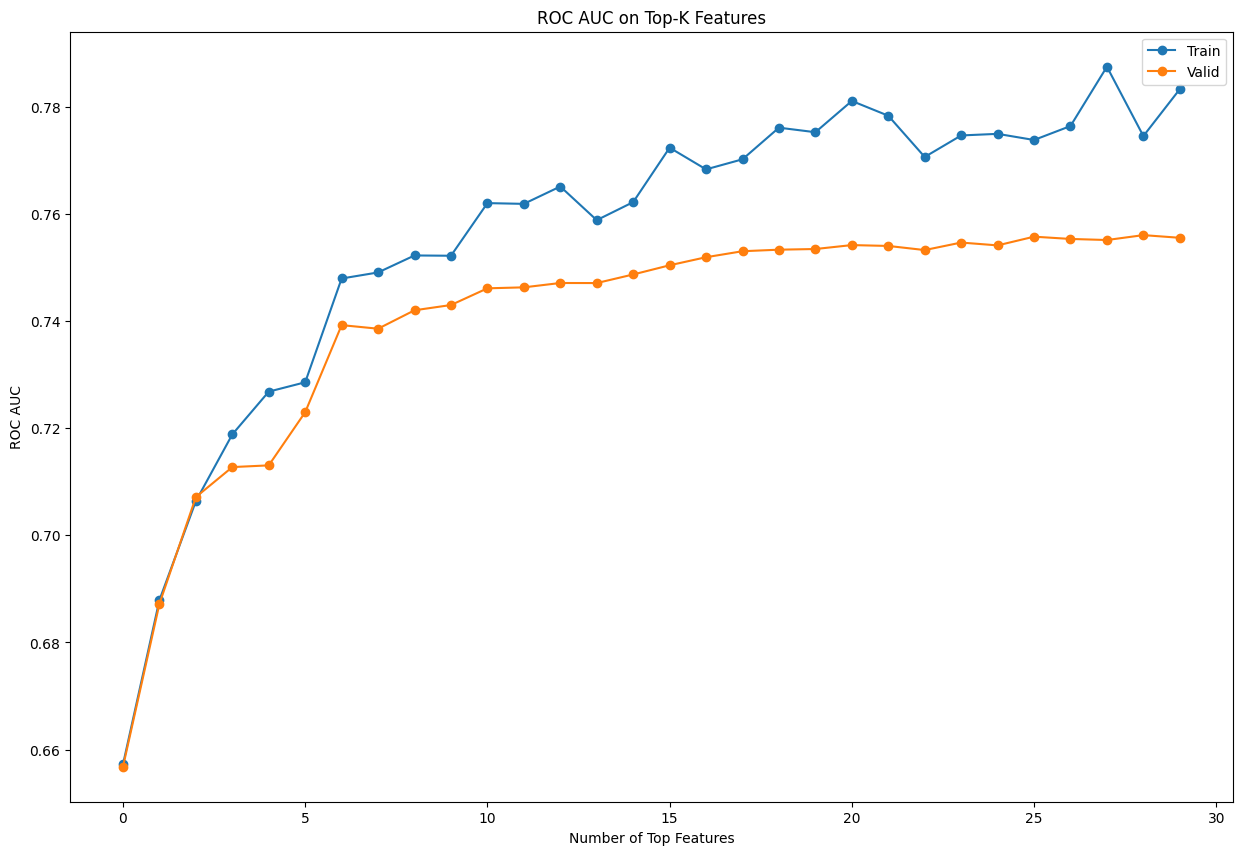

In [23]:
boosting.top_feats_selection()

## Optuna

In [24]:
opt_boosting = Boosting(X_train, X_val, y_train, y_val)

Init...
Init Finished!


In [25]:
opt_boosting.optimize_hyperparams()

[I 2024-03-09 16:10:59,395] A new study created in memory with name: no-name-8256db70-7970-4f3f-a3f8-3f891f7abde1
[I 2024-03-09 16:12:04,216] Trial 0 finished with value: 0.6757137909693828 and parameters: {'objective': 'Logloss', 'learning_rate': 2.5639835504774296e-05, 'l2_leaf_reg': 0.10093227243736153, 'colsample_bylevel': 0.011860601909054205, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 47, 'one_hot_max_size': 9, 'iterations': 505}. Best is trial 0 with value: 0.6757137909693828.
[I 2024-03-09 16:18:17,816] Trial 1 finished with value: 0.7524472198316634 and parameters: {'objective': 'Logloss', 'learning_rate': 0.1400806503733184, 'l2_leaf_reg': 0.0433433944998685, 'colsample_bylevel': 0.01900847450839733, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 23, 'one_hot_max_size': 23, 'iterations': 1947}. Best is trial 1 with value: 0.7524472198316634.
[I 2024-03-09 16:19:33,844] Trial 2 finished with value:

Best params: {'objective': 'Logloss', 'learning_rate': 0.044922042314700865, 'l2_leaf_reg': 2.3862248147920786, 'colsample_bylevel': 0.09432850402174302, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 37, 'one_hot_max_size': 9, 'iterations': 3082}


In [54]:
best_params = {
    'objective': 'Logloss', 
    'learning_rate': 0.044922042314700865, 
    'l2_leaf_reg': 2.3862248147920786, 
    'colsample_bylevel': 0.09432850402174302, 
    'depth': 5, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'MVS', 
    'min_data_in_leaf': 37, 
    'one_hot_max_size': 9, 
    'iterations': 3000,
    "eval_metric" : "AUC",
    'loss_function' : 'Logloss',
    'random_seed' : 42,
    'task_type' : 'CPU',
    'use_best_model' : True,
    'verbose' : 100
}

In [31]:
best_boosting = Boosting(X_train, X_val, y_train, y_val, params = best_params)

Init...
Init Finished!


In [32]:
best_boosting.train()

0:	test: 0.5119073	best: 0.5119073 (0)	total: 164ms	remaining: 2m 43s
100:	test: 0.7421032	best: 0.7421032 (100)	total: 16.3s	remaining: 2m 24s
200:	test: 0.7497426	best: 0.7497426 (200)	total: 32.7s	remaining: 2m 9s
300:	test: 0.7529782	best: 0.7529782 (300)	total: 48.7s	remaining: 1m 53s
400:	test: 0.7554203	best: 0.7554203 (400)	total: 1m 5s	remaining: 1m 37s
500:	test: 0.7567997	best: 0.7567997 (500)	total: 1m 21s	remaining: 1m 21s
600:	test: 0.7577699	best: 0.7577699 (600)	total: 1m 38s	remaining: 1m 5s
700:	test: 0.7585291	best: 0.7585341 (699)	total: 1m 54s	remaining: 48.8s
800:	test: 0.7589283	best: 0.7589298 (783)	total: 2m 11s	remaining: 32.6s
900:	test: 0.7592202	best: 0.7592202 (900)	total: 2m 27s	remaining: 16.2s
999:	test: 0.7594551	best: 0.7595726 (964)	total: 2m 43s	remaining: 0us

bestTest = 0.7595725886
bestIteration = 964

Shrink model to first 965 iterations.
ROC AUC на обучающей выборке: 0.7804265549444271
ROC AUC на валидационной выборке: 0.7595725886379766


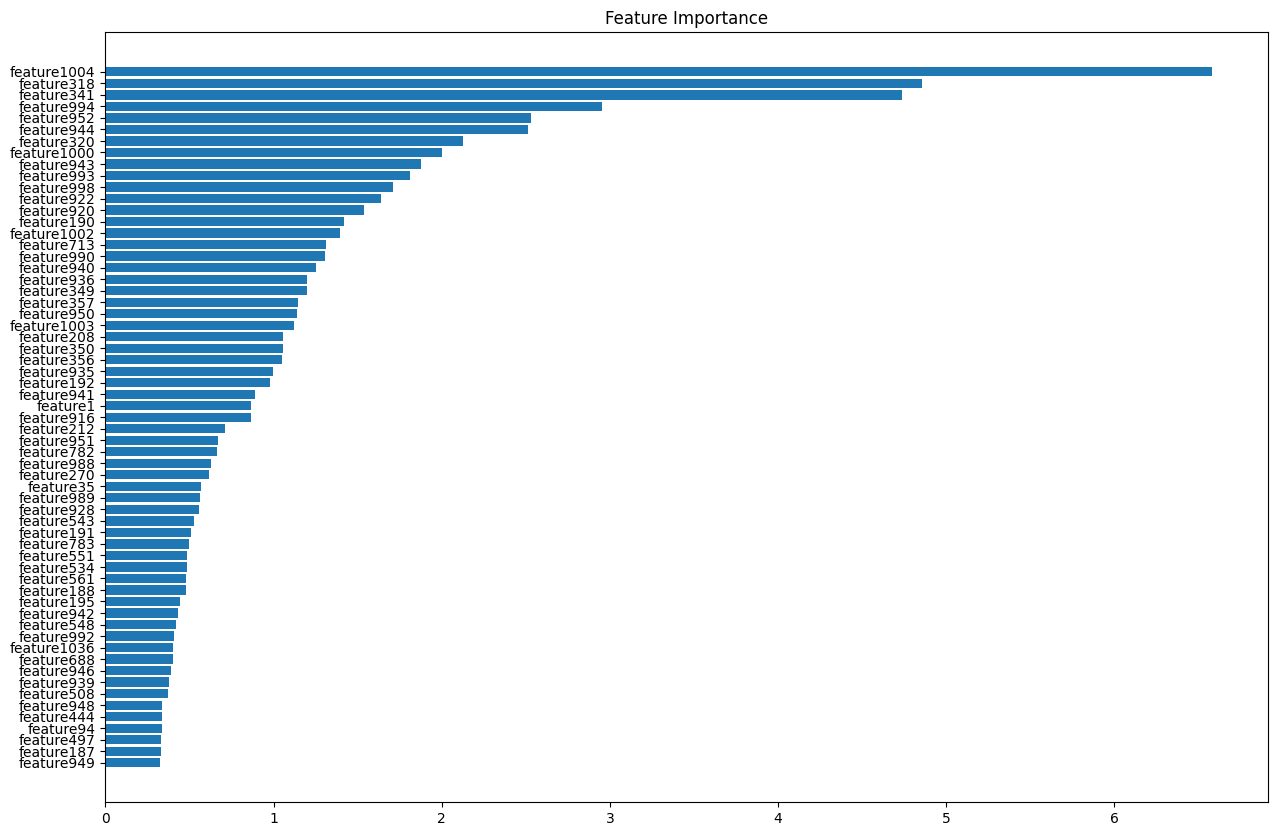

['feature1004' 'feature318' 'feature341' 'feature994' 'feature952'
 'feature944' 'feature320' 'feature1000' 'feature943' 'feature993'
 'feature998' 'feature922' 'feature920' 'feature190' 'feature1002'
 'feature713' 'feature990' 'feature940' 'feature936' 'feature349'
 'feature357' 'feature950' 'feature1003' 'feature208' 'feature350'
 'feature356' 'feature935' 'feature192' 'feature941' 'feature1'
 'feature916' 'feature212' 'feature951' 'feature782' 'feature988'
 'feature270' 'feature35' 'feature989' 'feature928' 'feature543'
 'feature191' 'feature783' 'feature551' 'feature534' 'feature561'
 'feature188' 'feature195' 'feature942' 'feature548' 'feature992'
 'feature1036' 'feature688' 'feature946' 'feature939' 'feature508'
 'feature948' 'feature444' 'feature94' 'feature497' 'feature187'
 'feature949']


In [33]:
best_boosting.show_feats_imp()

## Shortlist

In [59]:
feats = ['feature1004', 'feature318', 'feature341', 'feature994', 'feature952',
        'feature944', 'feature320', 'feature1000', 'feature943', 'feature993',
        'feature998', 'feature922', 'feature920', 'feature190', 'feature1002',
        'feature713', 'feature990', 'feature940', 'feature936', 'feature349',
        'feature357', 'feature950', 'feature1003', 'feature208', 'feature350',
        'feature356', 'feature935', 'feature192', 'feature941', 'feature1',
        'feature916', 'feature212', 'feature951', 'feature782', 'feature988',
        'feature270', 'feature35', 'feature989', 'feature928', 'feature543',
        'feature191', 'feature783', 'feature551', 'feature534', 'feature561',
        'feature188', 'feature195', 'feature942', 'feature548', 'feature992',
        'feature1036', 'feature688', 'feature946', 'feature939', 'feature508',
        'feature948', 'feature444', 'feature94', 'feature497', 'feature187',
        'feature949']

kostya = ['feature318', 'feature341', 'new1', 'feature952', 'feature1004',
       'feature994', 'feature950', 'feature208', 'feature320', 'feature936',
       'feature920', 'feature356', 'feature940', 'feature357', 'feature713',
       'feature1000', 'feature935', 'feature944', 'feature1', 'feature951',
       'feature349', 'log940', 'feature444', 'feature1003', 'feature1002',
       'feature993', 'feature190', 'feature988', 'feature861', 'feature922',
       'feature1036', 'feature943', 'feature287', 'feature309', 'feature94',
       'feature191', 'feature35', 'feature195', 'feature270', 'feature1069',
       'feature997', 'feature998', 'feature310', 'feature992', 'feature192',
       'feature990', 'feature534', 'feature989', 'feature948', 'feature210',
       'feature942', 'feature543', 'feature548', 'feature939', 'sin341',
       'feature532', 'feature758', 'feature985', 'feature212', 'feature139',
       'feature156', 'feature949', 'feature342', 'feature497', 'feature930',
       'feature688', 'feature898', 'feature546', 'feature435', 'feature941',
       'feature572', 'feature43', 'feature112', 'feature472', 'feature782',
       'feature47', 'feature551', 'feature869', 'feature559', 'feature862',
       'feature187', 'feature928', 'feature817', 'feature193', 'feature494',
       'feature128', 'feature946', 'feature1056', 'feature945', 'feature101'
]

feats = list(set(feats + kostya))
len(feats)

61

In [55]:
best_boosting_sl = Boosting(X_train[feats], X_val[feats], y_train, y_val, params = best_params)

Init...
Init Finished!


In [56]:
best_boosting_sl.train()

{'objective': 'Logloss', 'learning_rate': 0.044922042314700865, 'l2_leaf_reg': 2.3862248147920786, 'colsample_bylevel': 0.09432850402174302, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 37, 'one_hot_max_size': 9, 'iterations': 3000, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'random_seed': 42, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 100}
{'objective': 'Logloss', 'learning_rate': 0.044922042314700865, 'l2_leaf_reg': 2.3862248147920786, 'colsample_bylevel': 0.09432850402174302, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 37, 'one_hot_max_size': 9, 'iterations': 3000, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'random_seed': 42, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 100}
0:	test: 0.6341074	best: 0.6341074 (0)	total: 57.5ms	remaining: 2m 52s
100:	test: 0.7440337	best: 0.7440337 (100)	total: 5.43s	remaining: 2m 35s
200:	test: 0.7503519	best: 0.7503519 (200)	total: 11s	r

In [34]:
boosting.save_model("base_boosting.pkl")

In [35]:
best_boosting.save_model("opt_boosting.pkl")

In [ ]:
best_boosting_sl.save_model("opt_boosting_sl.pkl")

## Results

In [36]:
with open("base_boosting.pkl", 'rb') as file:
    base_boosting = pickle.load(file)
    
with open("opt_boosting.pkl", 'rb') as file:
    opt_boosting = pickle.load(file)

In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

print("BASE:")
predictions_auc = base_boosting.predict_proba(X_val)[:, 1]
print(f'roc_auc: {roc_auc_score(y_val, predictions_auc)}')
predictions = base_boosting.predict(X_val)
print(f'f1: {f1_score(y_val, predictions)}')
print(f'precision: {precision_score(y_val, predictions)}')
print(f'recall: {recall_score(y_val, predictions)}')

print("OPTUNA:")
predictions_auc = opt_boosting.predict_proba(X_val)[:, 1]
print(f'roc_auc: {roc_auc_score(y_val, predictions_auc)}')
predictions = opt_boosting.predict(X_val)
print(f'f1: {f1_score(y_val, predictions)}')
print(f'precision: {precision_score(y_val, predictions)}')
print(f'recall: {recall_score(y_val, predictions)}')

BASE:
roc_auc: 0.7583644360550653
f1: 0.0161839863713799
precision: 0.6129032258064516
recall: 0.008200258955545965
OPTUNA:
roc_auc: 0.7595725886379766
f1: 0.008151008151008153
precision: 0.6785714285714286
recall: 0.004100129477772983


In [39]:
from collections import Counter

predictions_train = base_boosting.predict(X_train)
predictions_val = base_boosting.predict(X_val)
print("BASE:")
print(Counter(predictions_train))
print(Counter(predictions_val))

predictions_train = opt_boosting.predict(X_train)
predictions_val = opt_boosting.predict(X_val)
print("OPTUNA:")
print(Counter(predictions_train))
print(Counter(predictions_val))

BASE:
Counter({0: 389315, 1: 396})
Counter({0: 129842, 1: 62})
OPTUNA:
Counter({0: 389554, 1: 157})
Counter({0: 129876, 1: 28})


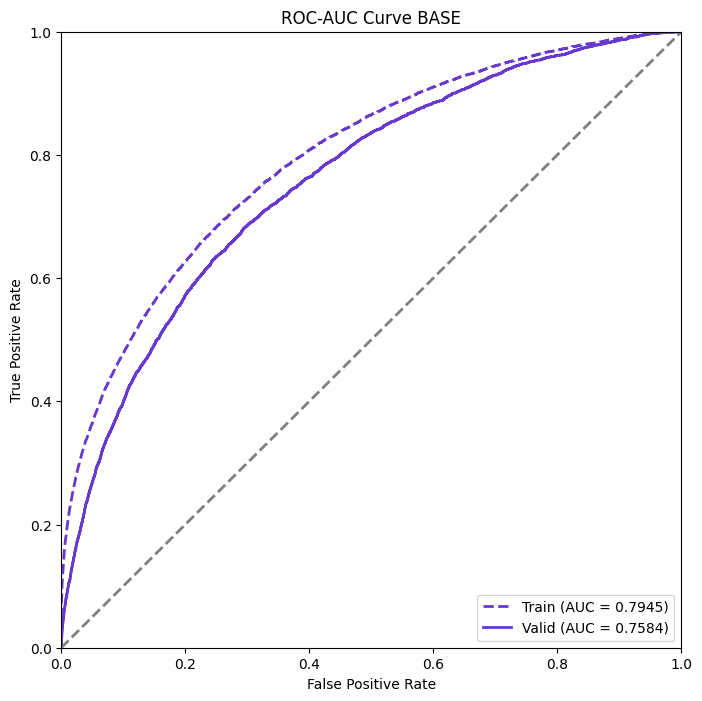

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label, color, linestyle):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.4f})', linestyle=linestyle)

y_true_train = y_train
y_scores_train = base_boosting.predict_proba(X_train)[:, 1]

y_true_valid = y_val
y_scores_valid = base_boosting.predict_proba(X_val)[:, 1]

roc_auc_color = '#6839CF'

plt.figure(figsize=(8, 8))

plot_roc_curve(y_true_train, y_scores_train, 'Train', color=roc_auc_color, linestyle='--')

plot_roc_curve(y_true_valid, y_scores_valid, 'Valid', color=roc_auc_color, linestyle='-')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve BASE')
plt.legend(loc="lower right")

plt.show()

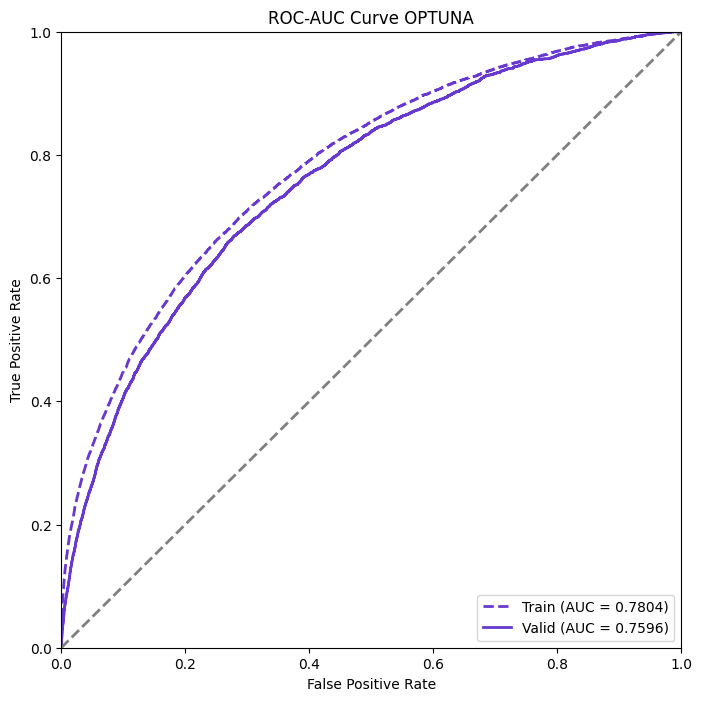

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label, color, linestyle):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.4f})', linestyle=linestyle)

y_true_train = y_train
y_scores_train = opt_boosting.predict_proba(X_train)[:, 1]

y_true_valid = y_val
y_scores_valid = opt_boosting.predict_proba(X_val)[:, 1]

roc_auc_color = '#6839CF'

plt.figure(figsize=(8, 8))

plot_roc_curve(y_true_train, y_scores_train, 'Train', color=roc_auc_color, linestyle='--')

plot_roc_curve(y_true_valid, y_scores_valid, 'Valid', color=roc_auc_color, linestyle='-')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve OPTUNA')
plt.legend(loc="lower right")

plt.show()